In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import plotly.express as px
import seaborn as sns
sns.set()
from sklearn import preprocessing
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


In [4]:
import sys,os
sys.path.insert(0, '../scripts/')
from data_preProcessing import dataProcessor
from data_exploration import dataExplorer
from data_cleaning import dataCleaner

In [5]:

nb_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


In [6]:
dl_df = pd.read_csv("../data/driver_locations_during_request.csv")
dl_df.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN


In [7]:
dl_df.drop('id',inplace=True, axis=1)
dl_df.drop('created_at',inplace=True, axis=1)
dl_df.drop('updated_at',inplace=True, axis=1)


In [8]:
train_df = pd.merge(nb_df,dl_df,left_on='Trip ID',right_on='order_id',how='inner')
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800


In [9]:
## objects of classes

pp = dataProcessor(train_df)
pp.show_data_information()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557740 entries, 0 to 1557739
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Trip ID           1557740 non-null  int64  
 1   Trip Origin       1557740 non-null  object 
 2   Trip Destination  1557740 non-null  object 
 3   Trip Start Time   1555718 non-null  object 
 4   Trip End Time     1557740 non-null  object 
 5   order_id          1557740 non-null  int64  
 6   driver_id         1557740 non-null  int64  
 7   driver_action     1557740 non-null  object 
 8   lat               1557740 non-null  float64
 9   lng               1557740 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 130.7+ MB


In [10]:
## unique column values
train_df.apply(lambda x: len(x.unique())).sort_values(ascending=False).head(20)

lat                 194406
lng                 170385
Trip ID              26492
order_id             26492
Trip End Time        25169
Trip Start Time      25155
Trip Destination     17563
Trip Origin          14578
driver_id             1213
driver_action            2
dtype: int64

# Missing values


In [11]:
pp.columns_WithMissingValue()

['Trip Start Time']

In [12]:
pp.c_missing_percentage()

,total_missing_values,missing_percentage
Trip ID,0,0.0 %
Trip Origin,0,0.0 %
Trip Destination,0,0.0 %
Trip Start Time,2022,0.13 %
Trip End Time,0,0.0 %
order_id,0,0.0 %
driver_id,0,0.0 %
driver_action,0,0.0 %
lat,0,0.0 %
lng,0,0.0 %


In [13]:
# null start time can be considered as the trip didnt take place. 
# so replace it with the end_time, so that the trip span is 0 overall.

train_df['Trip Start Time'] = train_df['Trip Start Time'].fillna(train_df['Trip End Time']) 

In [14]:
pp.columns_WithMissingValue()

[]

# result feature

In [15]:
# the result feature is weather an order is fulfilled or not. 
# fulfillment is implied by acceptance of an order + it should be ended within 30 minutes.
# i.e 'trip end time' - 'trip start time' <= 30minutes and driver_action = accepted
# we'll put 1 for fulfilled and 0 for unfullfilled in the fulfillment column

#convert to datetime
train_df['Trip Start Time'] = pd.to_datetime(train_df['Trip Start Time'], errors='coerce')
train_df['Trip End Time'] = pd.to_datetime(train_df['Trip End Time'], errors='coerce')

In [16]:

train_df['completion_minutes'] = ((train_df['Trip End Time'] - train_df['Trip Start Time']).dt.total_seconds()) / 60



In [17]:
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667


In [19]:
def add(row):
    if row['driver_action'] == "accepted" and row['completion_minutes'] < 30:
        val = 1
    else:
        val = 0
    return val

train_df['status'] = train_df.apply(add, axis=1)
train_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667,0
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667,0
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667,0


In [20]:
## check for holidays
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=train_df['Trip Start Time'].min(), end=train_df['Trip Start Time'].max())

train_df['is_holiday'] = train_df['Trip Start Time'].isin(holidays)
train_df.head()


,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,order_id,driver_id,driver_action,lat,lng,completion_minutes,status,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243828,accepted,6.602207,3.270465,3.616667,1,False
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243588,rejected,6.592097,3.287445,3.616667,0,False
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243830,rejected,6.596133,3.281784,3.616667,0,False
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,243539,rejected,6.596142,3.280526,3.616667,0,False
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,392001,171653,rejected,6.609232,3.288800,3.616667,0,False


In [21]:

train_df.to_csv('../data/merged.csv', index=False)

In [22]:
#y is the outcome lable fulfillment, and x is non-target features
y = train_df.status  #1 or 0
list_drop = ['status']
X = train_df.drop(list_drop, axis=1)

# UNIVARIATE ANALYSIS

In [23]:
exp = dataExplorer()
train_df['status'].value_counts()

0    1550483
1       7257
Name: status, dtype: int64

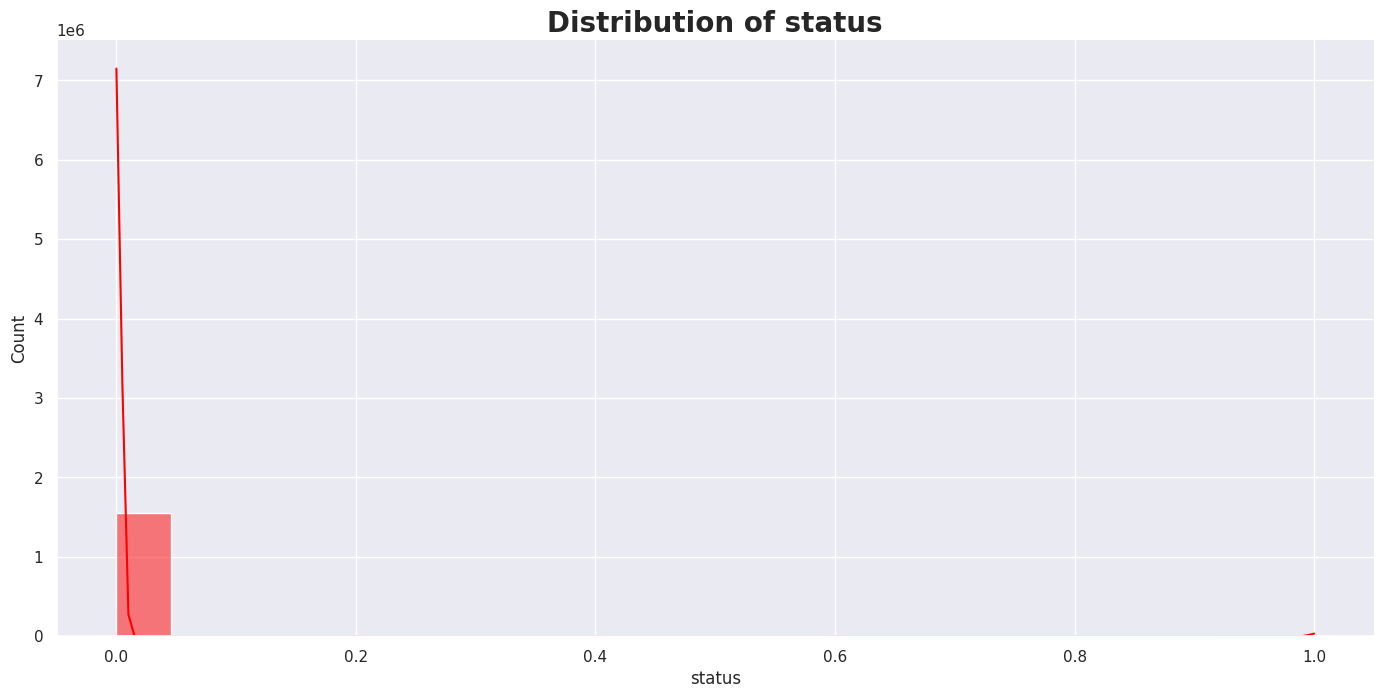

In [24]:
exp.plot_hist(train_df, 'status', 'red')

* There are some thousands of fulfilled orders as seen from the value_counts and the histogram

## BIVARIATE ANALYSIS

In [ ]:
## swarm plots
sns.set(style="whitegrid")
data_dia = y
data = X

#standardize
data_norm = (data - data.mean()) / (data.std())
#data = pd.concat([y,data_norm.iloc[0]])
data = pd.melt(data,id_vars="status",
                    var_name="features",
                    value_name="value")
plt.figure(figsize=(20,20))
sns.swarmplot(x="features", y="value",hue="diagnosis", data=data)
plt.xticks(rotation=90)